<a href="https://colab.research.google.com/github/erdemsirel/ozu_data_science/blob/master/DataScienceCaseThalia_Master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

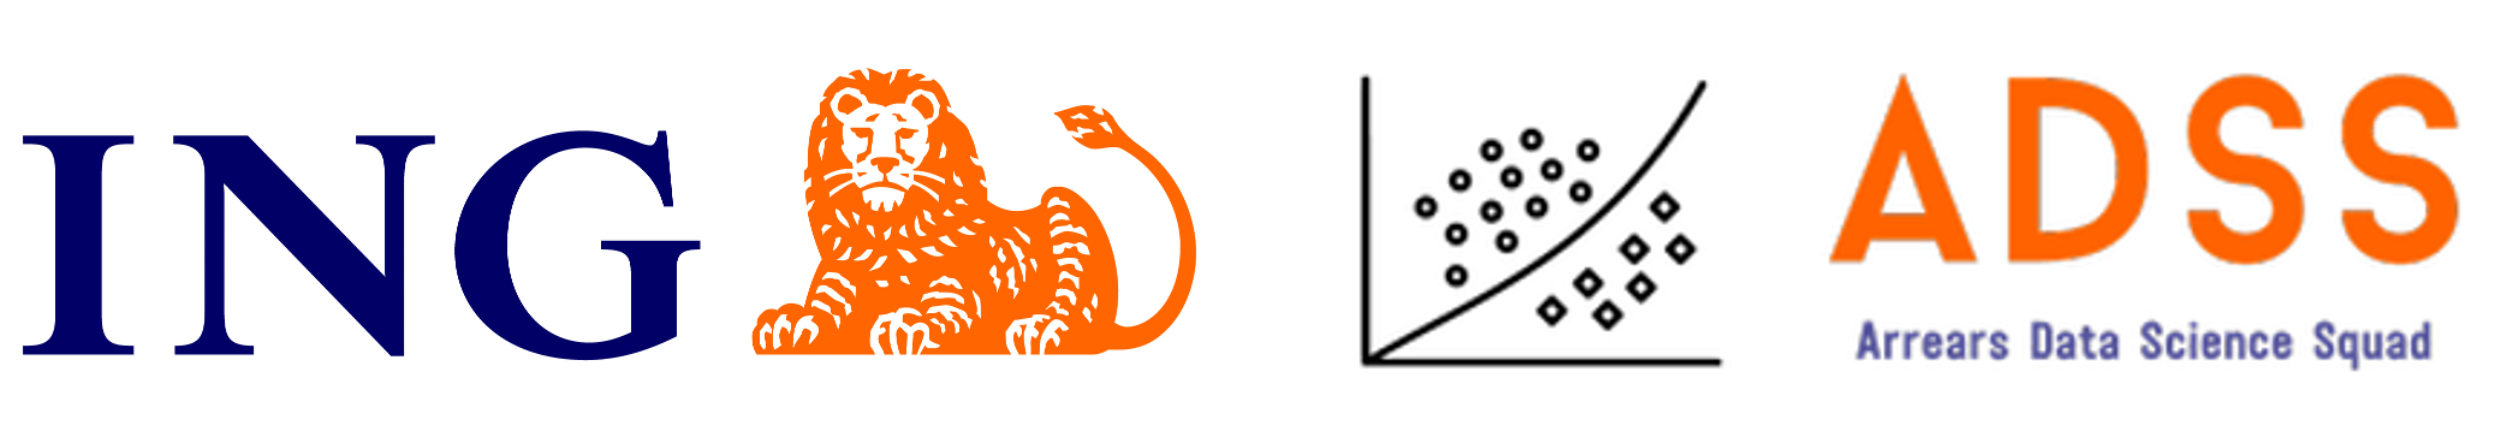

# Description

## Welcome to the case!  
**Are you up for a challenge where you will identify customers who experience financial difficulties via Machine Learning? Are you curious about how we do Data Science in ING?**  

In ING Collections, we are here to help customers when they experience financial difficulties. In this challenge, we will try to identify the risky loans and the customers with financial problems.
First, we will build a baseline machine learning model together, and you will have a chance to see our way of working and the basics of data science & machine learning.  
In the second part of the case, you will try to improve the baseline model by exploring some modeling techniques we use on a day-to-day basis.

## Aim
* Developing a model that can predict test data the best and minimising the costs.
* In the test data there are 8148 customers, 1812 of them are having financial issues. We need to identify and help them!
* You can only help 2000 of them with the existing capacity. 
* If you predict more than 2000 positive cases, each 75 predicted positive case will cost you €13000.
* Each positive case that you failed to identify will cost you €500.
* If you fail to identify at least 500 positive case correctly, you will get a €500000 fine!

*Credit For Data Source:* 
`https://www.kaggle.com/datasets/laotse/credit-risk-dataset`

# Import

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder,  MaxAbsScaler, RobustScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier

import math

# Define Utility Functions

In [ ]:
def classification_results(y_true, y_pred_proba, name="", threshold=0.5):
    proba_to_label = lambda proba: 1 if proba>threshold else 0
    y_pred_proba = pd.Series(y_pred_proba)
    
    roc_auc = metrics.roc_auc_score(y_true, y_pred_proba)
    accuracy = metrics.accuracy_score(y_true, y_pred_proba.apply(proba_to_label))
    precision = metrics.precision_score(y_true, y_pred_proba.apply(proba_to_label))
    recall = metrics.recall_score(y_true, y_pred_proba.apply(proba_to_label))
    f1_score = metrics.f1_score(y_true, y_pred_proba.apply(proba_to_label))
    tn_norm, fp_norm, fn_norm, tp_norm = metrics.confusion_matrix(y_true, y_pred_proba.apply(proba_to_label), normalize='all').ravel()
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred_proba.apply(proba_to_label)).ravel()
    
    result = pd.DataFrame({
        'roc_auc': [roc_auc],
        'accuracy': [accuracy],
        'precision': [precision],
        'recall': [recall],
        'f1_score': [f1_score],
        'tn_norm': [tn_norm],
        'fp_norm': [fp_norm],
        'fn_norm': [fn_norm],
        'tp_norm': [tp_norm],
        'tn': [tn],
        'fp': [fp],
        'fn': [fn],
        'tp': [tp]},
        index=[name]).round(3)

    return result

In [ ]:
def classification_results_test(y_pred_proba, threshold=0.5, name="Test"):
    y_test = pd.read_csv("https://raw.githubusercontent.com/erdemsirel/data_science_case/main/credit_risk_test_label.csv")['label']
    test_result = classification_results(y_true=y_test, y_pred_proba=y_pred_proba, name=name, threshold=threshold)
    tn = test_result.loc[name, 'tn']
    fp = test_result.loc[name, 'fp']
    fn = test_result.loc[name, 'fn']
    tp = test_result.loc[name, 'tp']
    predicted_positive = tp + fp
    excess_predicted_positive = math.ceil((predicted_positive-2000)/75) if  predicted_positive > 2000 else 0
    fail_to_identify_minimum_fine = 500000 if tp < 500 else 0

    test_result["Cost"] = excess_predicted_positive * 13000 + fn * 500 + fail_to_identify_minimum_fine
    return test_result

In [ ]:
def classification_results_combined(y_train, y_train_pred_proba, y_val, y_val_pred_proba, y_test_pred_proba, threshold=0.5, print_overfit=True):
    train_result = classification_results(y_true=y_train, y_pred_proba=y_train_pred_proba, name="Train", threshold=threshold)
    val_result = classification_results(y_true=y_val, y_pred_proba=y_val_pred_proba, name="Validation", threshold=threshold)
    test_result = classification_results_test(y_pred_proba=y_test_pred_proba, threshold=threshold, name="Test")
    if print_overfit:
        val_overfit = round(train_result.loc['Train', 'roc_auc'] - val_result.loc['Validation', 'roc_auc'],3)
        test_overfit = round(train_result.loc['Train', 'roc_auc'] - test_result.loc['Test', 'roc_auc'],3)
        if val_overfit > 0.05 or test_overfit > 0.05:
            print("WARNING: High Overfit \nWe expect to be less than 0.05! Otherwise, there is a high chance that your model won't perform as good as you expected.")
        print("Overfit AUC (Train-Val):", val_overfit)
        print("Overfit AUC (Train-Test):", test_overfit)
    return pd.concat([train_result, val_result, test_result], axis=0)


# Prepare Dummy Due Date and Paid Date

In [ ]:
data_raw = pd.read_csv("https://raw.githubusercontent.com/erdemsirel/data_science_case/main/credit_risk_dataset.csv")

In [ ]:
data_raw.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [ ]:
# # To be deleted

# data = pd.read_csv("https://raw.githubusercontent.com/erdemsirel/data_science_case/main/credit_risk_dataset.csv")
# np.random.seed(0)
# def add_duedate_and_pay_date(row):
#     if row['loan_status'] == 1:
#         row['paid_date'] = row['due_date'] + pd.to_timedelta(np.random.randint(31,31*3), unit='D')
#     else:
#         row['paid_date'] = row['due_date'] + pd.to_timedelta(np.random.randint(0,29), unit='D')
#     # Convert to string
#     row['due_date'] = row['due_date'].strftime('%Y-%m-%d')
#     row['paid_date'] = row['paid_date'].strftime('%Y%m%d')
#     return row
# data['due_date'] = data['loan_status'].apply(lambda x: pd.to_datetime('2021-06-01') + pd.to_timedelta(np.random.randint(0,365), unit='D'))
# data = data.apply(add_duedate_and_pay_date, axis=1)
# data.loc[(data['loan_status'] == 1) & (data.index < 100), 'paid_date'] = pd.NaT

# # Add label -1 cases
# indeterminate = data.sample(n=138).copy()
# indeterminate['loan_status'] = -1 
# indeterminate['due_date'] = indeterminate['due_date'].apply(lambda x: (pd.to_datetime('2022-10-07') - pd.to_timedelta(np.random.randint(0,28), unit='D')).strftime('%Y-%m-%d'))
# indeterminate['paid_date'] = None
# print(data.shape)
# data = pd.concat([data, indeterminate], axis='index').sample(frac=1).reset_index(drop=True)

# data["loan_int_amnt"] = (data["loan_int_rate"] * data["loan_amnt"]) / 100
# data = data.drop(columns=['loan_percent_income', 'loan_int_rate'])

# print(data.shape)

# data_to_be_saved = data.copy()
# data_to_be_saved_dev, data_to_be_saved_test = train_test_split(data_to_be_saved, test_size=0.25, random_state=32)

# data_to_be_saved_dev.reset_index(drop=True).drop(columns=["loan_status"]).to_csv("credit_risk_development_dataset.csv", index=True)

# data_to_be_saved_test = data_to_be_saved_test.reset_index(drop=True).rename(columns={'loan_status':'label'})
# data_to_be_saved_test = data_to_be_saved_test[data_to_be_saved_test['label'] >= 0]
# data_to_be_saved_test['due_date'] = '2022-10-01'
# data_to_be_saved_test.drop(columns=['label', 'paid_date']).to_csv("credit_risk_test_dataset.csv", index=True)
# data_to_be_saved_test[['label']].to_csv("credit_risk_test_label.csv", index=True)

# Load the Data

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/erdemsirel/data_science_case/main/credit_risk_development_dataset.csv").drop(columns=['Unnamed: 0'])
data.head(1)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,cb_person_default_on_file,cb_person_cred_hist_length,due_date,paid_date,loan_int_amnt
0,25,60000,RENT,1.0,VENTURE,A,8400,N,2,2022-01-19,20220206.0,612.36


In [ ]:
x_test_orj = pd.read_csv("https://raw.githubusercontent.com/erdemsirel/data_science_case/main/credit_risk_test_dataset.csv").drop(columns=['Unnamed: 0'])
x_test_orj.head(1)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,cb_person_default_on_file,cb_person_cred_hist_length,due_date,loan_int_amnt
0,27,72900,MORTGAGE,3.0,PERSONAL,D,10000,Y,9,2022-11-01,1570.0


# Exploratory Data Analysis

In [ ]:
data.describe()

,person_age,person_income,person_emp_length,loan_amnt,cb_person_cred_hist_length,paid_date,loan_int_amnt
count,24539.000000,2.453900e+04,23853.000000,24539.000000,24539.000000,2.438600e+04,22220.000000
mean,27.743959,6.585161e+04,4.788077,9558.581238,5.805616,2.021550e+07,1081.976453
std,6.394419,6.276772e+04,4.167102,6309.209533,4.052938,4.704722e+03,876.307628
min,20.000000,4.000000e+03,0.000000,500.000000,2.000000,2.021060e+07,48.800000
25%,23.000000,3.840000e+04,2.000000,5000.000000,3.000000,2.021093e+07,473.200000
50%,26.000000,5.500000e+04,4.000000,8000.000000,4.000000,2.021122e+07,813.410000
75%,30.000000,7.900000e+04,7.000000,12000.000000,8.000000,2.022033e+07,1419.600000
max,144.000000,6.000000e+06,123.000000,35000.000000,30.000000,2.022083e+07,6891.500000


In [ ]:
data.isnull().mean().rename("# of Missing Values")

person_age                    0.000000
person_income                 0.000000
person_home_ownership         0.000000
person_emp_length             0.027955
loan_intent                   0.000000
loan_grade                    0.000000
loan_amnt                     0.000000
cb_person_default_on_file     0.000000
cb_person_cred_hist_length    0.000000
due_date                      0.000000
paid_date                     0.006235
loan_int_amnt                 0.094503
Name: # of Missing Values, dtype: float64

In [ ]:
x_test_orj.isnull().mean().rename("# of Missing Values")

person_age                    0.000000
person_income                 0.000000
person_home_ownership         0.000000
person_emp_length             0.026141
loan_intent                   0.000000
loan_grade                    0.000000
loan_amnt                     0.000000
cb_person_default_on_file     0.000000
cb_person_cred_hist_length    0.000000
due_date                      0.000000
loan_int_amnt                 0.099165
Name: # of Missing Values, dtype: float64

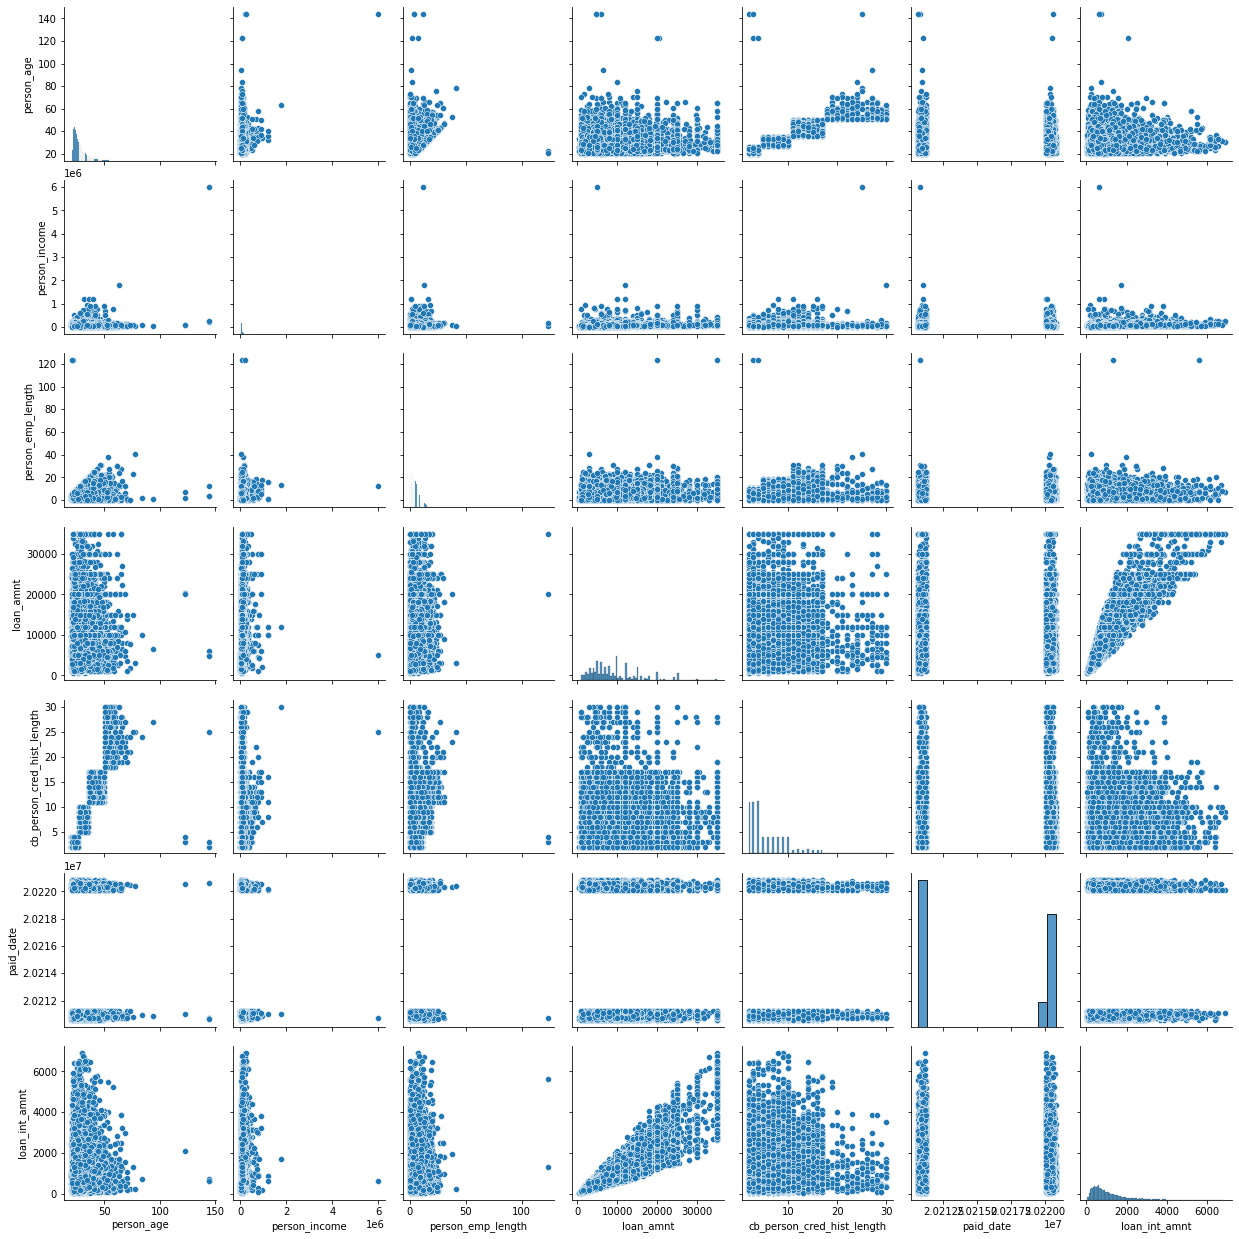

In [ ]:
sns.pairplot(data)
plt.show()

# Data Processing

## Building the label

In [ ]:
data['due_date'] = pd.to_datetime(data['due_date'], format='%Y-%m-%d')
data['paid_date'] = pd.to_datetime(data['paid_date'], format='%Y%m%d')

In [ ]:
mask_paid = (~data['paid_date'].isna())
mask_paid_date_30_days_past_due_date = (data['paid_date'] - data['due_date']).dt.days > 30
mask_current_date_30_days_past_due_date = (pd.to_datetime('2022-10-07') - data['due_date']).dt.days > 30

data.loc[mask_paid & mask_paid_date_30_days_past_due_date, "label"] = 1
data.loc[mask_paid & (~mask_paid_date_30_days_past_due_date), "label"] = 0
data.loc[(~mask_paid) & (mask_current_date_30_days_past_due_date), "label"] = 1
data.loc[(~mask_paid) & (~mask_current_date_30_days_past_due_date), "label"] = -1
data = data[data["label"] >= 0]


In [ ]:
data_with_label_orj = data.copy()

Postive Class Ratio 0.217


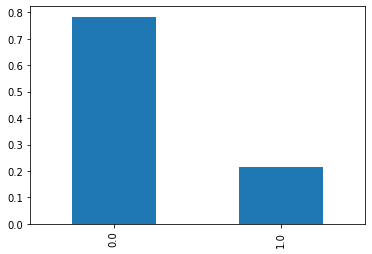

In [ ]:
class_ratio = data.label.value_counts(normalize=True)
class_ratio.plot(kind='bar')
print("Postive Class Ratio", class_ratio[1].round(3))

# Building the Baseline Model

In [ ]:
data = data_with_label_orj.copy()
x_test = x_test_orj.copy()
data.head(1)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,cb_person_default_on_file,cb_person_cred_hist_length,due_date,paid_date,loan_int_amnt,label
0,25,60000,RENT,1.0,VENTURE,A,8400,N,2,2022-01-19,2022-02-06,612.36,0.0


In [ ]:
data = data.drop(columns=['due_date', 'paid_date'])
x_test = x_test.drop(columns=['due_date'])

data.head(1)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,cb_person_default_on_file,cb_person_cred_hist_length,loan_int_amnt,label
0,25,60000,RENT,1.0,VENTURE,A,8400,N,2,612.36,0.0


In [ ]:
data = pd.get_dummies(data, columns=["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"])
x_test = pd.get_dummies(x_test, columns=["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"])

data.head(1)

,person_age,person_income,person_emp_length,loan_amnt,cb_person_cred_hist_length,loan_int_amnt,label,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,25,60000,1.0,8400,2,612.36,0.0,0,0,0,...,1,1,0,0,0,0,0,0,1,0


In [ ]:
# Drop NA for development data
print("Number of rows before NA removal:", data.shape[0])
data = data.dropna()
print("Number of rows after NA removal:", data.shape[0])

# Drop NA for test data
print("Number of rows before NA removal (test):", x_test.shape[0])
x_test = x_test.dropna()
print("Number of rows after NA removal (test):", x_test.shape[0])

Number of rows before NA removal: 24433
Number of rows after NA removal: 21495
Number of rows before NA removal (test): 8148
Number of rows after NA removal (test): 7143


In [ ]:
x = data.drop(columns='label')

y = data['label']

x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.33, random_state=32)
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

x_train shape: (14401, 25)
y_train shape: (14401,)
x_val shape: (7094, 25)
y_val shape: (7094,)


In [ ]:
model = RandomForestClassifier(random_state=32)

In [ ]:
model.fit(x_train, y_train)

RandomForestClassifier(random_state=32)

In [ ]:
classification_results(y_val, model.predict_proba(x_val)[:,1], name="validation")

,roc_auc,accuracy,precision,recall,f1_score,tn_norm,fp_norm,fn_norm,tp_norm,tn,fp,fn,tp
validation,0.919,0.919,0.927,0.676,0.782,0.773,0.011,0.07,0.146,5486,81,494,1033


In [ ]:
# classification_results_test(y_pred_proba=model.predict_proba(x_test)[:,1])

In [ ]:
feat_imp = pd.Series(model.feature_importances_, index = x_train.columns.tolist()).sort_values(ascending=False)
feat_imp

person_income                     0.240689
loan_int_amnt                     0.135929
loan_amnt                         0.111220
loan_grade_D                      0.077607
person_emp_length                 0.068717
person_age                        0.057634
cb_person_cred_hist_length        0.046022
person_home_ownership_RENT        0.037051
loan_grade_E                      0.025597
loan_intent_DEBTCONSOLIDATION     0.023878
loan_intent_MEDICAL               0.022717
person_home_ownership_MORTGAGE    0.019061
loan_grade_C                      0.018646
loan_intent_HOMEIMPROVEMENT       0.016658
person_home_ownership_OWN         0.014972
loan_grade_A                      0.013636
loan_intent_EDUCATION             0.012299
loan_grade_B                      0.011849
loan_intent_PERSONAL              0.010173
loan_intent_VENTURE               0.009773
cb_person_default_on_file_N       0.008669
cb_person_default_on_file_Y       0.007886
loan_grade_F                      0.005533
loan_grade_

# Improving the Baseline Model

In [ ]:
data = data_with_label_orj.copy()
x_test = x_test_orj.copy()

x = data.drop(columns='label')
y = data['label']

In [ ]:
model = RandomForestClassifier(random_state=32)

numeric_features = x_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = x_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', model)])



In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.33, random_state=32)
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

x_train shape: (16370, 12)
y_train shape: (16370,)
x_val shape: (8063, 12)
y_val shape: (8063,)


In [ ]:
model_pipeline.fit(x_train, y_train)
print("")

In [ ]:
classification_results(y_val, model_pipeline.predict_proba(x_val)[:,1], name="validation")

,roc_auc,accuracy,precision,recall,f1_score,tn_norm,fp_norm,fn_norm,tp_norm,tn,fp,fn,tp
validation,0.87,0.859,0.752,0.51,0.608,0.749,0.036,0.105,0.11,6039,291,849,884


In [ ]:
classification_results_test(y_pred_proba=model_pipeline.predict_proba(x_test)[:,1], threshold=0.5)

,roc_auc,accuracy,precision,recall,f1_score,tn_norm,fp_norm,fn_norm,tp_norm,tn,fp,fn,tp,Cost
Test,0.871,0.853,0.754,0.505,0.605,0.741,0.037,0.11,0.112,6037,299,897,915,448500


In [ ]:
classification_results_combined(y_train=y_train, 
                                y_train_pred_proba=model_pipeline.predict_proba(x_train)[:,1], 
                                y_val=y_val, 
                                y_val_pred_proba=model_pipeline.predict_proba(x_val)[:,1], 
                                y_test_pred_proba=model_pipeline.predict_proba(x_test)[:,1], 
                                threshold=0.5)

We expect to be less than 0.05! Otherwise, there is a high chance that your model won't perform as good as you expected.
Overfit AUC (Train-Val): 0.13
Overfit AUC (Train-Test): 0.129


,roc_auc,accuracy,precision,recall,f1_score,tn_norm,fp_norm,fn_norm,tp_norm,tn,fp,fn,tp,Cost
Train,1.000,1.000,1.000,1.000,1.000,0.782,0.000,0.000,0.218,12807,0,0,3563,NaN
Validation,0.870,0.859,0.752,0.510,0.608,0.749,0.036,0.105,0.110,6039,291,849,884,NaN
Test,0.871,0.853,0.754,0.505,0.605,0.741,0.037,0.110,0.112,6037,299,897,915,448500.0


## Outlier Handling

In [ ]:
stats = x_train.describe().T
stats['IQR'] = stats['75%'] - stats['25%']
stats['lower_threshold'] = stats['25%'] - stats['IQR'] * 1.5
stats['upper_threshold'] = stats['75%'] + stats['IQR'] * 1.5

feat_imp_order = [feat for feat in feat_imp.index if feat in stats.index]
stats.loc[feat_imp_order].loc[stats['max']>1]

,count,mean,std,min,25%,50%,75%,max,IQR,lower_threshold,upper_threshold
person_income,16370.0,66045.346426,52081.218584,4000.0,38400.00,55000.0,79631.75,1782000.0,41231.75,-23447.625,141479.375
loan_int_amnt,14835.0,1084.874604,884.660989,48.8,476.35,810.7,1411.00,6891.5,934.65,-925.625,2812.975
loan_amnt,16370.0,9571.763897,6342.737428,500.0,5000.00,8000.0,12000.00,35000.0,7000.00,-5500.000,22500.000
person_emp_length,15908.0,4.793186,4.124848,0.0,2.00,4.0,7.00,123.0,5.00,-5.500,14.500
person_age,16370.0,27.746121,6.316141,20.0,23.00,26.0,30.00,144.0,7.00,12.500,40.500
cb_person_cred_hist_length,16370.0,5.797984,4.019630,2.0,3.00,4.0,8.00,30.0,5.00,-4.500,15.500


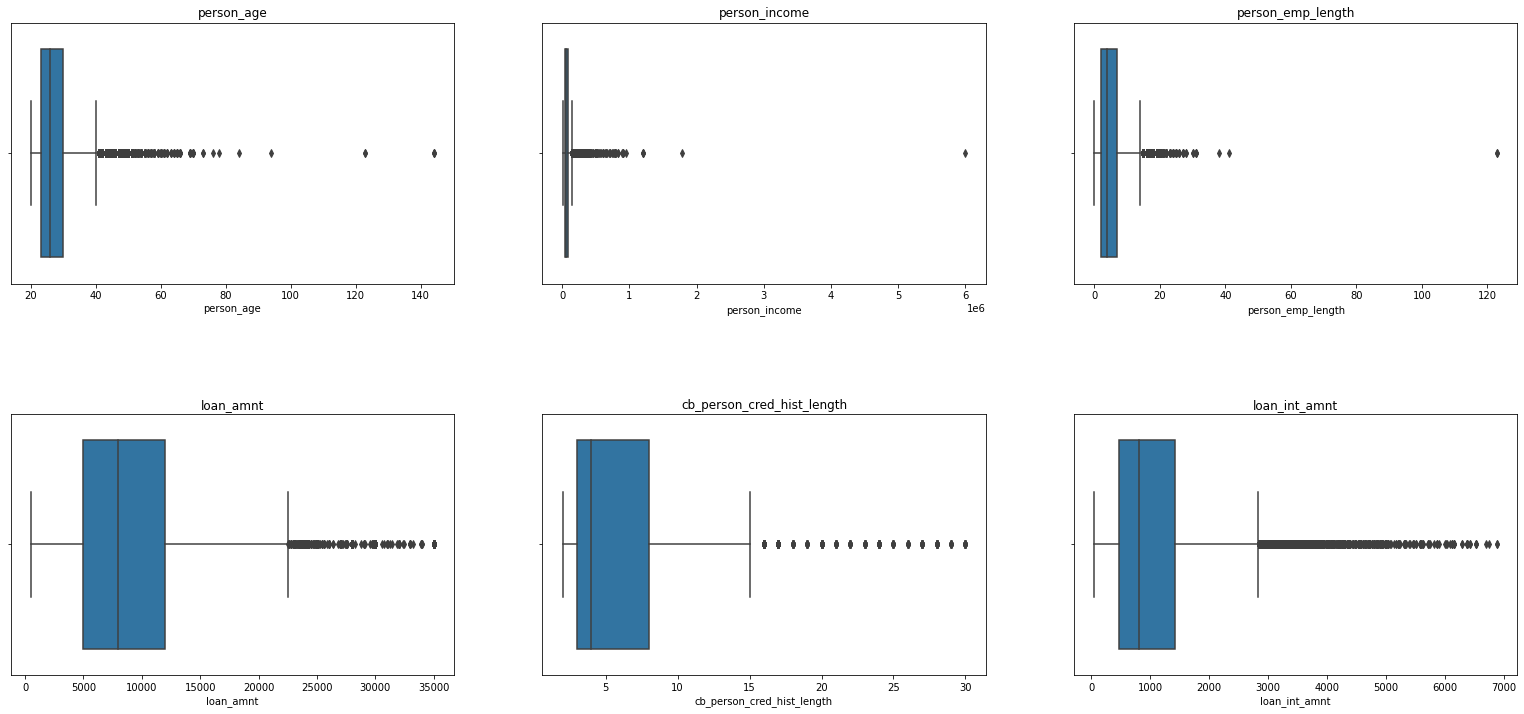

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(9*3, 4*3))
fig.subplots_adjust(hspace=0.5)
axes = (ax for ax in axes.flat)
for col in data.select_dtypes(include=['int64', 'float64']).columns:
    if data[col].nunique()==2: continue
    ax_ = sns.boxplot(data=data, x=col, ax=next(axes))
    ax_.set_title(col)
plt.show()

In [ ]:
# Cap person_age above 85
# Cap person_income above 140000
# Cap person_emp_length above 20

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.33, random_state=32)

x_train['person_age'] = x_train['person_age'].mask(x_train['person_age'] >= 85, 85)
x_train['person_income'] = x_train['person_income'].mask(x_train['person_income'] >= 140000, 140000)
x_train['person_emp_length'] = x_train['person_emp_length'].mask(x_train['person_emp_length'] >= 20, 20)

In [ ]:
model_pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'cb_person_cred_hist_length', 'loan_int_amnt'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))])

In [ ]:
classification_results_combined(y_train=y_train, 
                                y_train_pred_proba=model_pipeline.predict_proba(x_train)[:,1], 
                                y_val=y_val, 
                                y_val_pred_proba=model_pipeline.predict_proba(x_val)[:,1], 
                                y_test_pred_proba=model_pipeline.predict_proba(x_test)[:,1], 
                                threshold=0.5)

We expect to be less than 0.05! Otherwise, there is a high chance that your model won't perform as good as you expected.
Overfit AUC (Train-Val): 0.129
Overfit AUC (Train-Test): 0.128


,roc_auc,accuracy,precision,recall,f1_score,tn_norm,fp_norm,fn_norm,tp_norm,tn,fp,fn,tp,Cost
Train,1.000,1.000,1.000,0.999,0.999,0.782,0.000,0.000,0.217,12806,1,3,3560,NaN
Validation,0.871,0.858,0.748,0.511,0.607,0.748,0.037,0.105,0.110,6032,298,848,885,NaN
Test,0.872,0.852,0.753,0.499,0.600,0.741,0.036,0.111,0.111,6039,297,908,904,454000.0


## Feature Engineering

In [ ]:
data = data_with_label_orj.copy()
x_test = x_test_orj.copy()

In [ ]:
data['loan_int_rate'] = data['loan_int_amnt'] / data['loan_amnt']
data['loan_to_income_ratio'] = data['loan_amnt'] / data['person_income']

x_test['loan_int_rate'] = x_test['loan_int_amnt'] / x_test['loan_amnt']
x_test['loan_to_income_ratio'] = x_test['loan_amnt'] / x_test['person_income']


In [ ]:
x = data.drop(columns='label')
y = data['label']

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.33, random_state=32)

In [ ]:
model_pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'cb_person_cred_hist_length', 'loan_int_amnt'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))])

In [ ]:
classification_results_combined(y_train=y_train, 
                                y_train_pred_proba=model_pipeline.predict_proba(x_train)[:,1], 
                                y_val=y_val, 
                                y_val_pred_proba=model_pipeline.predict_proba(x_val)[:,1], 
                                y_test_pred_proba=model_pipeline.predict_proba(x_test)[:,1], 
                                threshold=0.5)

We expect to be less than 0.05! Otherwise, there is a high chance that your model won't perform as good as you expected.
Overfit AUC (Train-Val): 0.13
Overfit AUC (Train-Test): 0.129


,roc_auc,accuracy,precision,recall,f1_score,tn_norm,fp_norm,fn_norm,tp_norm,tn,fp,fn,tp,Cost
Train,1.000,1.000,1.000,1.000,1.000,0.782,0.000,0.000,0.218,12807,0,0,3563,NaN
Validation,0.870,0.859,0.752,0.510,0.608,0.749,0.036,0.105,0.110,6039,291,849,884,NaN
Test,0.871,0.853,0.754,0.505,0.605,0.741,0.037,0.110,0.112,6037,299,897,915,448500.0


## Correlated Feature Removal

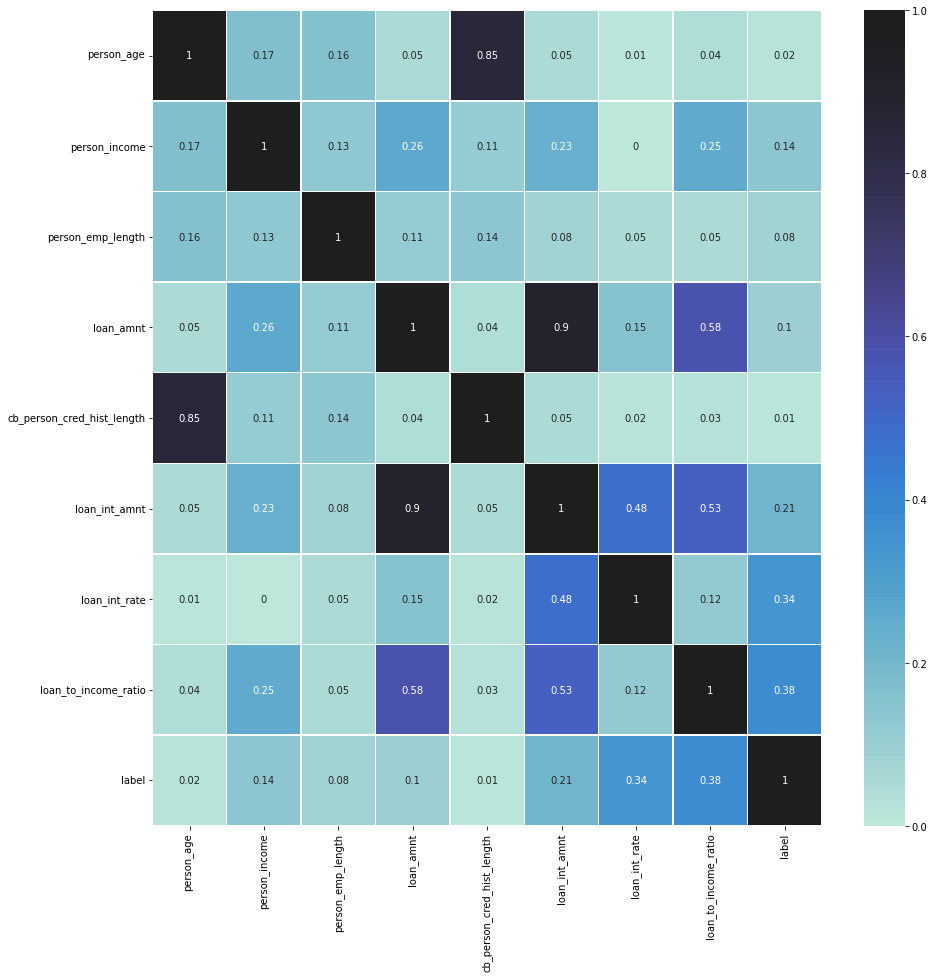

In [ ]:
col_order = data.columns.tolist()
# to move label rightmost side, first remove from the list 
# and add it back to at the end of the list
col_order.remove('label')
col_order.append('label')

correlations = data[col_order].corr().abs().round(2)
f, ax = plt.subplots(figsize = (15,15))
sns.heatmap(correlations, annot=True,linewidths=.5, center=1)

In [ ]:
columns_to_drop = ["loan_amnt", "cb_person_cred_hist_length"]
data = data.drop(columns=columns_to_drop)
x_test = x_test.drop(columns=columns_to_drop)

In [ ]:
x = data.drop(columns='label')
y = data['label']

x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.33, random_state=32)

In [ ]:
model = RandomForestClassifier(random_state=32)

numeric_features = x_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = x_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', model)])



In [ ]:
model_pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['person_age', 'person_income', 'person_emp_length', 'loan_int_amnt',
       'loan_int_rate', 'loan_to_income_ratio'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),


In [ ]:
classification_results_combined(y_train=y_train, 
                                y_train_pred_proba=model_pipeline.predict_proba(x_train)[:,1], 
                                y_val=y_val, 
                                y_val_pred_proba=model_pipeline.predict_proba(x_val)[:,1], 
                                y_test_pred_proba=model_pipeline.predict_proba(x_test)[:,1], 
                                threshold=0.5)

We expect to be less than 0.05! Otherwise, there is a high chance that your model won't perform as good as you expected.
Overfit AUC (Train-Val): 0.073
Overfit AUC (Train-Test): 0.067


,roc_auc,accuracy,precision,recall,f1_score,tn_norm,fp_norm,fn_norm,tp_norm,tn,fp,fn,tp,Cost
Train,1.000,1.000,1.000,1.000,1.000,0.782,0.000,0.000,0.218,12807,0,0,3563,NaN
Validation,0.927,0.933,0.958,0.719,0.821,0.778,0.007,0.060,0.155,6275,55,487,1246,NaN
Test,0.933,0.936,0.970,0.735,0.836,0.773,0.005,0.059,0.163,6295,41,480,1332,240000.0


## Handling Missing Data

In [ ]:
data = data_with_label_orj.copy()
x_test = x_test_orj.copy()

x = data.drop(columns='label')
y = data['label']

x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.33, random_state=32)

In [ ]:
model = RandomForestClassifier(random_state=32)

numeric_features = x_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = x_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', model)])



In [ ]:
model_pipeline.fit(x_train, y_train)
print("model fitted")

model fitted


In [ ]:
classification_results(y_val, model_pipeline.predict_proba(x_val)[:,1], name="validation")

,roc_auc,accuracy,precision,recall,f1_score,tn_norm,fp_norm,fn_norm,tp_norm,tn,fp,fn,tp
validation,0.922,0.921,0.922,0.692,0.791,0.773,0.013,0.066,0.149,6229,101,534,1199


In [ ]:
classification_results_test(y_pred_proba=model_pipeline.predict_proba(x_test)[:,1])

,roc_auc,accuracy,precision,recall,f1_score,tn_norm,fp_norm,fn_norm,tp_norm,tn,fp,fn,tp,Cost
Test,0.925,0.927,0.944,0.714,0.813,0.768,0.009,0.064,0.159,6259,77,518,1294,259000


## Preprocessing

### OrdinalEncoder 

In [ ]:
data = data_with_label_orj.copy()
x_test = x_test_orj.copy()

x = data.drop(columns='label')
y = data['label']

x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.33, random_state=32)

In [ ]:
train_data = pd.concat([x_train, y_train], axis=1)
display(train_data.groupby(['person_home_ownership'])['label'].mean().sort_values())
display(train_data.groupby(['loan_grade'])['label'].mean().sort_values())

person_home_ownership
OWN         0.076687
MORTGAGE    0.126727
OTHER       0.288136
RENT        0.313316
Name: label, dtype: float64

loan_grade
A    0.097340
B    0.160955
C    0.211416
D    0.594505
E    0.632696
F    0.677686
G    0.974359
Name: label, dtype: float64

In [ ]:
person_home_ownership_order = train_data.groupby(['person_home_ownership'])['label'].mean().sort_values().index.tolist()
loan_grade_order = train_data.groupby(['loan_grade'])['label'].mean().sort_values().index.tolist()

In [ ]:
model = RandomForestClassifier(random_state=32)

numeric_features = x_train.select_dtypes(include=['int64', 'float64']).columns
ordinal_features = ['person_home_ownership', 'loan_grade']
categorical_features = list(set(x_train.select_dtypes(include=['object']).columns) - set(ordinal_features))

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder(categories=[person_home_ownership_order, loan_grade_order]))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)
        ])

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', model)])



In [ ]:
model_pipeline.fit(x_train, y_train)
print("model fitted")

model fitted


In [ ]:
classification_results(y_val, model_pipeline.predict_proba(x_val)[:,1], name="validation")

,roc_auc,accuracy,precision,recall,f1_score,tn_norm,fp_norm,fn_norm,tp_norm,tn,fp,fn,tp
validation,0.925,0.924,0.932,0.698,0.798,0.774,0.011,0.065,0.15,6242,88,524,1209


In [ ]:
classification_results_test(y_pred_proba=model_pipeline.predict_proba(x_test)[:,1])

,roc_auc,accuracy,precision,recall,f1_score,tn_norm,fp_norm,fn_norm,tp_norm,tn,fp,fn,tp,Cost
Test,0.926,0.929,0.952,0.716,0.817,0.77,0.008,0.063,0.159,6271,65,515,1297,257500


## Hyper-parameter Optimisation

In [ ]:
data = data_with_label_orj.copy()
x_test = x_test_orj.copy()

x = data.drop(columns='label')
y = data['label']

x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.33, random_state=32)

In [ ]:
model = RandomForestClassifier(random_state=32)

train_data = pd.concat([x_train, y_train], axis=1)
person_home_ownership_order = train_data.groupby(['person_home_ownership'])['label'].mean().sort_values().index.tolist()
loan_grade_order = train_data.groupby(['loan_grade'])['label'].mean().sort_values().index.tolist()

numeric_features = x_train.select_dtypes(include=['int64', 'float64']).columns
ordinal_features = ['person_home_ownership', 'loan_grade']
categorical_features = list(set(x_train.select_dtypes(include=['object']).columns) - set(ordinal_features))

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder(categories=[person_home_ownership_order, loan_grade_order]))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)
        ])

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', model)])

In [ ]:
param_grid = { 
    'classifier__n_estimators': [100, 200, 400, 1000],
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__max_depth' : [5, 10, 20, 40, 50, None],
    'classifier__criterion' :['gini', 'entropy']
}



model_pipeline_grid = RandomizedSearchCV(model_pipeline, 
                    param_distributions = param_grid,
                    n_iter=30,
                    cv = 3,  
                    scoring = 'roc_auc', 
                    verbose = 100, 
                    n_jobs = 1, 
                    random_state=32
                    )

In [ ]:
model_pipeline_grid.fit(x_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 1/3; 1/30] START classifier__criterion=entropy, classifier__max_depth=50, classifier__max_features=auto, classifier__min_samples_split=5, classifier__n_estimators=400
[CV 1/3; 1/30] END classifier__criterion=entropy, classifier__max_depth=50, classifier__max_features=auto, classifier__min_samples_split=5, classifier__n_estimators=400;, score=0.920 total time=   7.6s
[CV 2/3; 1/30] START classifier__criterion=entropy, classifier__max_depth=50, classifier__max_features=auto, classifier__min_samples_split=5, classifier__n_estimators=400
[CV 2/3; 1/30] END classifier__criterion=entropy, classifier__max_depth=50, classifier__max_features=auto, classifier__min_samples_split=5, classifier__n_estimators=400;, score=0.926 total time=   7.5s
[CV 3/3; 1/30] START classifier__criterion=entropy, classifier__max_depth=50, classifier__max_features=auto, classifier__min_samples_split=5, classifier__n_estimators=400
[CV 3/3; 1/30] END cla

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer())]),
                                                                               Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'cb_person_cred_hist_length', 'loan_int_amnt'],
      dtype='object')),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value='missing'...
                                              R

In [ ]:
classification_results(y_val, model_pipeline_grid.predict_proba(x_val)[:,1], name="validation")

,roc_auc,accuracy,precision,recall,f1_score,tn_norm,fp_norm,fn_norm,tp_norm,tn,fp,fn,tp
validation,0.93,0.924,0.936,0.695,0.798,0.775,0.01,0.065,0.149,6247,83,528,1205


In [ ]:
classification_results_test(y_pred_proba=model_pipeline_grid.predict_proba(x_test)[:,1])

,roc_auc,accuracy,precision,recall,f1_score,tn_norm,fp_norm,fn_norm,tp_norm,tn,fp,fn,tp,Cost
Test,0.931,0.929,0.955,0.715,0.818,0.77,0.007,0.063,0.159,6275,61,517,1295,258500


In [ ]:
classification_results_combined(y_train=y_train, 
                                y_train_pred_proba=model_pipeline_grid.predict_proba(x_train)[:,1], 
                                y_val=y_val, 
                                y_val_pred_proba=model_pipeline_grid.predict_proba(x_val)[:,1], 
                                y_test_pred_proba=model_pipeline_grid.predict_proba(x_test)[:,1], 
                                threshold=0.5)

We expect to be less than 0.05! Otherwise, there is a high chance that your model won't perform as good as you expected.
Overfit AUC (Train-Val): 0.07
Overfit AUC (Train-Test): 0.069


,roc_auc,accuracy,precision,recall,f1_score,tn_norm,fp_norm,fn_norm,tp_norm,tn,fp,fn,tp,Cost
Train,1.000,0.983,1.000,0.922,0.959,0.782,0.000,0.017,0.201,12806,1,278,3285,NaN
Validation,0.930,0.924,0.936,0.695,0.798,0.775,0.010,0.065,0.149,6247,83,528,1205,NaN
Test,0.931,0.929,0.955,0.715,0.818,0.770,0.007,0.063,0.159,6275,61,517,1295,258500.0


## Model Selection

In [ ]:
data = data_with_label_orj.copy()
x_test = x_test_orj.copy()

x = data.drop(columns='label')
y = data['label']

x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.33, random_state=32)

In [ ]:
model = LGBMClassifier(random_state=32)

train_data = pd.concat([x_train, y_train], axis=1)
person_home_ownership_order = train_data.groupby(['person_home_ownership'])['label'].mean().sort_values().index.tolist()
loan_grade_order = train_data.groupby(['loan_grade'])['label'].mean().sort_values().index.tolist()

numeric_features = x_train.select_dtypes(include=['int64', 'float64']).columns
ordinal_features = ['person_home_ownership', 'loan_grade']
categorical_features = list(set(x_train.select_dtypes(include=['object']).columns) - set(ordinal_features))

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder(categories=[person_home_ownership_order, loan_grade_order]))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)
        ])

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', model)])

In [ ]:
model_pipeline.fit(x_train, y_train)
print("")

In [ ]:
classification_results_combined(y_train=y_train, 
                                y_train_pred_proba=model_pipeline.predict_proba(x_train)[:,1], 
                                y_val=y_val, 
                                y_val_pred_proba=model_pipeline.predict_proba(x_val)[:,1], 
                                y_test_pred_proba=model_pipeline.predict_proba(x_test)[:,1], 
                                threshold=0.5)

Overfit AUC (Train-Val): 0.032
Overfit AUC (Train-Test): 0.031


,roc_auc,accuracy,precision,recall,f1_score,tn_norm,fp_norm,fn_norm,tp_norm,tn,fp,fn,tp,Cost
Train,0.973,0.942,0.980,0.747,0.848,0.779,0.003,0.055,0.163,12753,54,901,2662,NaN
Validation,0.941,0.930,0.944,0.716,0.815,0.776,0.009,0.061,0.154,6257,73,492,1241,NaN
Test,0.942,0.931,0.951,0.729,0.825,0.769,0.008,0.060,0.162,6268,68,491,1321,245500.0


# Optimising the model based on capacity and cost

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


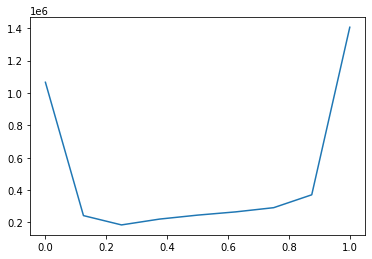

In [ ]:
pd.concat([classification_results_test(y_pred_proba=model_pipeline.predict_proba(x_test)[:,1], 
                                threshold=threshold, 
                                name=threshold)
            for threshold in np.linspace(0, 1, 9)
            ])["Cost"].plot()